In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { margin-left: 0 !important; width:100% !important; }</style>"))

In [2]:
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import json
from types import SimpleNamespace
import cmath
import glob
import itertools
import tensorboard
import time

np.set_printoptions(floatmode='maxprec')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [129]:
# example0:
# {
#   "EntryType":"EquivalentLoudnessMeasurement",
#   "Calibration":{
#     "HeadphoneFrequencyResponseHash":"eab807a5050b0087109ac1fd6fecbd09197a3dcd",
#     "FullScaleSineDBSPL":100
#   },
#   "Run":{
#     "ID":"1599737802659_2857050667"
#   },
#   "Evaluation":{
#     "ID":"1599738237070_2365796582",
#     "Frequency":697.9866246810275,
#     "Probe":{
#       "Type":"Noise",
#       "Params":{
#         "Level":-10,
#         "LowerLimit":966.84025,
#         "Onset":{
#           "Delay":0,
#           "Duration":0.1
#         },
#         "UpperLimit":1033.15975
#       }
#     },
#     "Combined":{
#       "Type":"Superposition",
#       "Params":[
#         {
#           "Params":{
#             "Level":-40,
#             "LowerLimit":966.84025,
#             "Onset":{
#               "Delay":0.5,
#               "Duration":0.1
#             },
#             "UpperLimit":1033.15975
#           },
#           "Type":"Noise"
#         },{
#           "Params":{
#             "Level":-20,
#             "LowerLimit":672.9766301106662,
#             "Onset":{
#               "Delay":0,
#               "Duration":0.1
#             },
#             "UpperLimit":722.9966192513888
#           },
#           "Type":"Noise"
#         }
#       ]
#     }
#   },
#   "Results":{
#     "ProbeGainForEquivalentLoudness":0.003107877399956887,
#     "ProbeDBSPLForEquivalentLoudness":39.84927756697657
#   }
# }
def experiment_result_to_example(exp, car_fs_sine_db_spl=100, window_size=2048, sample_rate=48000, noise_floor_db_spl=30):
    if exp.EntryType != 'EquivalentLoudnessMeasurement':
        return None
    assert exp.Evaluation.Probe.Type == 'Noise'
    assert exp.Evaluation.Combined.Type == 'Superposition'
    for part in exp.Evaluation.Combined.Params:
        assert part.Type == 'Noise'
        # If this part isn't the probe.
        if (part.Params.LowerLimit != exp.Evaluation.Probe.Params.LowerLimit or
            part.Params.UpperLimit != exp.Evaluation.Probe.Params.UpperLimit):
            # We want to ignore evaluations where probe and masker overlap.
            if ((part.Params.LowerLimit >= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.LowerLimit <= exp.Evaluation.Probe.Params.UpperLimit) or
                (part.Params.UpperLimit >= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.UpperLimit <= exp.Evaluation.Probe.Params.UpperLimit) or
                (part.Params.LowerLimit <= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.UpperLimit >= exp.Evaluation.Probe.Params.UpperLimit)):
                return None
    assert exp.Results.ProbeGainForEquivalentLoudness > 0
    assert exp.Results.ProbeDBSPLForEquivalentLoudness != None
    assert exp.Calibration.FullScaleSineDBSPL > 0

    bin_width = sample_rate / window_size
    def add_noise(coeffs, lower_limit, upper_limit, total_power_db_fs):
        first_bin = int(np.floor(lower_limit/bin_width))
        last_bin = int(np.ceil(upper_limit/bin_width))
        noise_coeffs = (complex(0, 1) * np.random.normal(size=[last_bin-first_bin]) + 
                        np.random.normal(size=[last_bin-first_bin]))
        noise_power_db_fs = 10 * np.log10(np.sum(noise_coeffs ** 2))
        scale = 10 ** ((total_power_db_fs - noise_power_db_fs) / 20)
        noise_coeffs *= scale
        for bin_idx in range(first_bin, first_bin + 1):
            coeffs[bin_idx] += noise_coeffs[bin_idx - first_bin]
            coeffs[-bin_idx] += np.conjugate(coeffs[bin_idx])
    coeffs = np.zeros([window_size], dtype=np.complex128)
    add_noise(coeffs, 20, 14000, noise_floor_db_spl - car_fs_sine_db_spl)
    for part in exp.Evaluation.Combined.Params:
        part_db_spl = exp.Calibration.FullScaleSineDBSPL + part.Params.Level
        part_db_fs = part_db_spl - car_fs_sine_db_spl
        add_noise(coeffs, part.Params.LowerLimit, part.Params.UpperLimit, part_db_fs)
    
    relevant_bins = np.zeros([int(window_size/2)], dtype=np.complex128)
    first_relevant_bin = int(np.floor(exp.Evaluation.Probe.Params.LowerLimit/bin_width))
    last_relevant_bin = int(np.ceil(exp.Evaluation.Probe.Params.UpperLimit/bin_width))
    for bin_idx in range(first_relevant_bin, last_relevant_bin + 1):
        relevant_bins[bin_idx] = 1

    true_loudness = np.array([exp.Results.ProbeDBSPLForEquivalentLoudness], dtype=np.complex128)
    
    res = tf.concat([np.fft.ifft(coeffs), true_loudness, relevant_bins], axis=0)
    return res

def load_examples(glb, car_fs_sine_db_spl=100, window_size=2048, sample_rate=48000):
    lines_iter = itertools.chain(*map(lambda f: open(f).readlines(), glob.glob(glb)))
    json_iter = map(lambda l: json.loads(l, object_hook=lambda o: SimpleNamespace(**o)), lines_iter)
    only_eval_iter = filter(lambda exp: exp.EntryType == 'EquivalentLoudnessMeasurement', json_iter)
    sorted_iter = sorted(only_eval_iter, key=lambda exp: exp.Evaluation.ID)
    examples_iter = map(lambda l: experiment_result_to_example(l, car_fs_sine_db_spl=car_fs_sine_db_spl, window_size=window_size, sample_rate=sample_rate), sorted_iter)
    filtered_iter = filter(lambda e: e != None, examples_iter)
    ds = tf.data.Dataset.from_tensor_slices(list(filtered_iter))
    input_true_ds = ds.map(lambda ex: (ex[:window_size], ex[window_size:]))
    return input_true_ds
            
def plot_pz(f):
    _, ax = plt.subplots(figsize=(8,8))
    ax.add_patch(patches.Circle((0,0),
                              radius=1,
                              fill=False,
                              color='black',
                              ls='solid',
                              alpha=0.1))
    ax.axvline(0, color='0.7')
    ax.axhline(0, color='0.7')
    ax.set_xlim((-1.1,1.1))
    ax.set_ylim((-1.1,1.1))

    ax.plot(tf.reshape(tf.math.real(f.poles), [-1,1]), tf.reshape(tf.math.imag(f.poles), [-1,1]),
            'x', markersize=9, alpha=0.5)
    ax.plot(tf.reshape(tf.math.real(f.zeros), [-1,1]), tf.reshape(tf.math.imag(f.zeros), [-1,1]),
            'o', color='none', markeredgecolor='red',
            markersize=9, alpha=0.5)
    plt.show()

def plot_many_z(many_z, sample_rate=48000, figsize=(12,4)):
    xaxis = np.tile(np.linspace(0,
                                (many_z.shape[1] - 1) * sample_rate *
                                0.5 / many_z.shape[1],
                                many_z.shape[1]), [many_z.shape[0], 1])
    _, ax = plt.subplots(figsize=figsize)    
    ax.set_xscale('log')
    ax.set_xlim((10,20000))
    ax.set_ylim((-20, 70))
    x = np.transpose(xaxis[:,:xaxis.shape[1]//2])
    y = np.transpose(20 * np.log10(np.abs(many_z[:,:many_z.shape[1]//2])))
    ax.plot(x, y)
    plt.show()
        
def plot_snr(snr, channels=[None, None], bins=[None, None]):
    max_snr = np.nanmax(snr)
    min_snr = np.nanmin(snr)
    scaled_snr = ((snr - min_snr) / (max_snr - min_snr))[:,:,None]
    if channels[1] != None:
        scaled_snr = scaled_snr[:channels[1]]
    if channels[0] != None:
        scaled_snr = scaled_snr[channels[0]]
    if bins[1] != None:
        scaled_snr= scaled_snr[:,:bins[1]]
    if bins[0] != None:
        scaled_snr = scaled_snr[:,bins[0]:]
    scaled_snr = np.repeat(scaled_snr, 4, axis=0)
    pixels = np.concatenate([scaled_snr, scaled_snr/2, scaled_snr/2], axis=2)
    plt.figure(figsize = (20,10))
    plt.imshow(pixels, interpolation='bicubic')
    plt.show()
    
def plot_pred(model, ds):
    truth = []
    pred = []
    worst_example = None
    worst_error = None
    worst_index = None
    example_index = 0
    for ex in ds:
        x, y_true = ex
        for val in y_true[:,0]:
            truth.append(np.abs(val))
        y_pred = model(x)
        pred_min = np.min(y_pred, axis=1)[:,None]
        irrelevant_reduced = np.where(np.abs(y_true[:,1:]) != 0, y_pred, pred_min-1)
        for idx, val in enumerate(np.max(irrelevant_reduced, axis=1)):
            pred.append(val)
            err = (truth[idx] - val) ** 2 * truth[idx]            
            if worst_error == None or err > worst_error:
                worst_error = err
                worst_example = x[idx]
                worst_index = example_index
            example_index += 1
    plt.figure(figsize=(20,10))
    steps = np.arange(len(truth))
    plt.plot(steps, truth)
    plt.plot(steps, pred)
    plt.show()
    return (worst_index, worst_error, worst_example)

@tf.function
def coeffs(constants):
    res = tf.TensorArray(size=constants.shape[0]+1, dtype=tf.complex128)
    for num in range(constants.shape[0]+1):
        if num == 0:
            s = tf.constant(1.0, dtype=tf.complex128)
        else:
            s = tf.constant(0.0, dtype=tf.complex128)
            for parts in itertools.combinations(np.arange(constants.shape[0]), num):
                prod = tf.constant(1.0, dtype=tf.complex128)
                for part in parts:
                    prod *= -constants[part]
                s += prod
        res = res.write(num, s)
    return res.stack()

class PZCell:
    def __init__(self, gain, poles, zeros):
        self.gain = gain
        self.poles = poles
        self.zeros = zeros
        self.state_size = [[2, 2*poles.shape[0]+1]]
        self.output_size = 1
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return tf.zeros(shape=[batch_size, self.state_size[0][0], self.state_size[0][1]], dtype=tf.float64)
    # [batch], [batch, x/y, steps_back] - 0 is at t-1 => [batch], [batch, x/y, steps_back] - 0 is at t
    @tf.function
    def call(self, input_at_t, states_at_t):
        poles = tf.concat([self.poles, tf.math.conj(self.poles)], axis=0)
        zeros = tf.concat([self.zeros, tf.math.conj(self.zeros)], axis=0)
        # [batch, 1]
        input_at_t = tf.cast(input_at_t, dtype=tf.complex128)[:,None]
        # [batch, x/y, steps_back] - 0 is at t-1
        states_at_t = tf.cast(states_at_t, dtype=tf.complex128)
        # [batch, steps_back] - 0 is input at t
        x_memory = tf.concat([input_at_t, states_at_t[:,0,:states_at_t.shape[2]-1]], axis=1)
        # [batch, steps_back] - 0 is output at t-1
        y_memory = states_at_t[:,1,:]
        # [coeff]
        pole_coeffs = coeffs(poles)
        # [coeff]
        zero_coeffs = coeffs(zeros)
        zero_offset = tf.math.maximum(0, pole_coeffs.shape[0] - zero_coeffs.shape[0])
        # [batch, 1]
        output_at_t = tf.constant(0, shape=input_at_t.shape, dtype=tf.complex128)
        # [coeff]
        zero_components = x_memory[:,zero_offset:] * self.gain * zero_coeffs
        # [batch, 1]
        output_at_t += tf.math.reduce_sum(zero_components, axis=1)[:,None]
        # [coeff]
        pole_components = y_memory[:,:y_memory.shape[1]-1] * pole_coeffs[1:]
        # [batch, 1]
        output_at_t -= tf.math.reduce_sum(pole_components, axis=1)[:, None]
        # [batch, 1]
        output_at_t = tf.math.divide_no_nan(output_at_t, pole_coeffs[0])
        # [batch, steps_back] - 0 is t
        y_memory = tf.concat([output_at_t, y_memory[:, :y_memory.shape[1]-1]], axis=1)
        # [batch]
        states_at_t_plus_1 = tf.concat([x_memory[:,None,:], y_memory[:,None,:]], axis=1)
        # [batch]
        output_at_t = tf.reshape(output_at_t, [output_at_t.shape[0]])
        # [batch], [batch, x/y, steps_back] - 0 is at t
        return (tf.math.real(output_at_t), tf.math.real(states_at_t_plus_1))
        
class RNNWrapperLayer(tf.keras.layers.Layer):
    def __init__(self, rnn_cell, **kwargs):
        super().__init__(self, **kwargs)
        self.rnn_cell = rnn_cell
    def build(self, input_shape):
        self.rnn_state = self.rnn_cell.get_initial_state(inputs=None, batch_size=input_shape[0], dtype=tf.float64)
    # [batch, sample] => [batch, sample]
    @tf.function
    def call(self, inputs, **kwargs):
        def cond(output, state, step):
            return step < inputs.shape[1]
        def body(output, state, step):
            step_output, state = self.rnn_cell.call(inputs[:, step], state)
            output = output.write(step, step_output)
            return output, state, step + 1
        output, state, _ = tf.while_loop(cond=cond,
                                         body=body,
                                         loop_vars=[tf.TensorArray(size=inputs.shape[1], dtype=tf.float64), self.rnn_state, tf.constant(0, dtype=tf.int32)],
                                         shape_invariants=[None, self.rnn_state.shape, tf.TensorShape(())])
        self.rnn_state = state
        res = output.stack()
        dims = np.arange(len(res.shape))
        dims[0] = 1
        dims[1] = 0
        output = tf.transpose(res, dims)
        return output

def pz_filter(gain, poles, zeros, inputs):
    all_zeros = tf.concat([zeros, tf.math.conj(zeros)], axis=0)
    all_poles = tf.concat([poles, tf.math.conj(poles)], axis=0)
    z = tf.exp(tf.complex(tf.cast(0.0, tf.math.real(gain).dtype),
                          tf.linspace(
                              tf.cast(0.0, tf.math.imag(gain).dtype), 
                              # (inputs.shape[1] - 1) / inputs.shape[1] to not include 2*pi 
                              (inputs.shape[1] - 1)*2*math.pi/inputs.shape[1],
                              inputs.shape[1])), name='z')
    return (gain *
            tf.cast(inputs, gain.dtype) *
            tf.math.reduce_prod(z[None,:,None] - all_zeros[None,None,:], axis=2) /
            tf.math.reduce_prod(z[None,:,None] - all_poles[None,None,:], axis=2))

class CARCell:
    # See 'Human and Machine Hearing' (http://dicklyon.com/hmh/), 16.2-16.3,
    # and https://github.com/google/carfac/.
    def __init__(self, sample_rate=48000, erb_per_step=0.5):
        self._erb_per_step = erb_per_step
        self._sample_rate = sample_rate
        # [z1, z2]
        self.state_size = [[2]]

        # Based on the assumtion that max small-signal gain at the passband peak
        # will be on the order of (0.5/min_zeta)^(1/erb_per_step), and we need
        # the start value of that in the same region or the loss function becomes
        # too uneven to optimize.
        def compute_zeta(zeta_at_default_erb_per_step, erb_per_step):
            default_erb_per_step = 0.5
            max_small_signal_gain = (0.5 /
                                     zeta_at_default_erb_per_step) ** (1 / default_erb_per_step)
            return 0.5 / (max_small_signal_gain ** erb_per_step)

        # Controls r (pole and zero abs value) which controls damping relative to
        # frequency.
        self._high_f_damping_compression = tf.Variable(
            name='high_f_damping_compression',
            dtype=tf.float64,
            initial_value=0.5)
        # Controls distance from pole to zero.
        self._zero_ratio = tf.Variable(
            name='zero_ratio',
            dtype=tf.float64,
            initial_value=(2 ** 0.5))
        # min/max zeta controls max damping.
        self._min_zeta = tf.Variable(
            name='min_zeta',
            dtype=tf.float64,
            initial_value=compute_zeta(0.1, self._erb_per_step))
        self._max_zeta = tf.Variable(
            name='max_zeta',
            dtype=tf.float64,
            initial_value=compute_zeta(0.35, self._erb_per_step))
        # Controls how we convert from Hz to Cams.
        # Defaults at numbers from B.C.J. Moore and B.R. Glasberg, "Suggested formulae for calculating auditory-filter bandwidths and excitation patterns".
        self._erb_constant_0 = tf.Variable(
            name='erb_constant_0(24.7)',
            dtype=tf.float64,
            initial_value=24.7)
        self._erb_constant_1 = tf.Variable(
            name='erb_constant_1(1.0)',
            dtype=tf.float64,
            initial_value=1)
        self._erb_constant_2 = tf.Variable(
            name='erb_constant_2(4.37)',
            dtype=tf.float64,
            initial_value=4.37)
        self._max_freq = 20000
        self._min_freq = 20
        f = self._max_freq
        self._n_poles = 1
        while f - self._erb_per_step * self.ERB(f) > self._min_freq:
            f = f - self._erb_per_step * self.ERB(f)
            self._n_poles += 1
    # Equivalent rectangular bandwidth, the width of the theoretical rectangular cochlear place filter.
    def ERB(self, f):
        return self._erb_constant_0 * (self._erb_constant_1 + self._erb_constant_2 * f * 0.001)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        self._batch_size = batch_size
        return tf.zeros(shape=[batch_size, self._n_poles, self.state_size[0][0]], dtype=tf.float64)
    # [batch], [batch, x/y, steps_back] - 0 is at t-1 => [batch], [batch, x/y, steps_back] - 0 is at t
    @tf.function
    def call(self, input_at_t, states_at_t):
        input_at_t = tf.cast(input_at_t, dtype=tf.float64)
        #print('cc call input', input_at_t.shape, states_at_t.shape)

        pole_freqs_ta = tf.TensorArray(size=self._n_poles, dtype=tf.float64)
        f = self._max_freq
        for channel_number in range(self._n_poles):
            pole_freqs_ta = pole_freqs_ta.write(channel_number, f)
            f -= self._erb_per_step * self.ERB(f)
        pole_freqs = pole_freqs_ta.stack()
        #print('cc call pole_freqs', pole_freqs.shape)

        # From the matlab code:
        # zero_ratio comes in via h.  In book's circuit D, zero_ratio is 1/sqrt(a),
        # and that a is here 1 / (1+f) where h = f*c.
        # solve for f:  1/zero_ratio^2 = 1 / (1+f)
        # zero_ratio^2 = 1+f => f = zero_ratio^2 - 1
        f = tf.math.square(self._zero_ratio) - 1
        pole_thetas = pole_freqs * 2 * np.pi / self._sample_rate
        # The book assigns a0 and c0 thus to simplify the equations.
        a0 = tf.math.cos(pole_thetas)
        c0 = tf.math.sin(pole_thetas)
        #print('cc call a0 c0', a0.shape, c0.shape)

        # The ratio between each pole and max measurable frequency.
        x = pole_thetas / np.pi

        # From the matlab code:
        # When high_f_damping_compression is 0 this is just theta, when
        # high_f_damping_compression is 1 it approaches 0 as theta approaches pi.
        zr_coeffs = np.pi * (x - self._high_f_damping_compression * tf.math.pow(x, 3))

        # The book is not super easy to follow here, so I have mostly
        # implemented the same math as the matlab and c++ code.

        r1 = (1 - zr_coeffs * self._max_zeta)
        min_zetas = self._min_zeta + (0.25 * ((self.ERB(pole_freqs) / pole_freqs) - self._min_zeta))
        zr_coeffs *= (self._max_zeta - min_zetas)
        r = r1 + zr_coeffs
        h = c0 * f
        g0 = tf.cast((1 - 2 * r * a0 + tf.math.square(r)) / (1 - 2 * r * a0 + h * r * c0 + tf.math.square(r)), tf.complex128)
        
        # Following is based on matlab code and figures 16.1 and 17.1 from the book. In figure 17.1
        # I have used the names U and V in the same way as in figure 16.1.
        prev_u = states_at_t[:, :, 0]
        prev_v = states_at_t[:, :, 1]
        
        #print('cc call r, prev_u, prev_v', r.shape, prev_u.shape, prev_v.shape)
        # This doesn't include the input X
        partial_u = r * (a0 * prev_u - c0 * prev_v)
        # V doesn't include the input 
        v = r * (c0 * prev_u + a0 * prev_v)
        #print('cc call v, partial_u', v.shape, partial_u.shape)
        
        # This doesn't include the input X
        partial_y = h * v
        #print('cc call partial_y, g0', partial_y.shape, g0.shape)
        
        u_ta = tf.TensorArray(size=self._n_poles, dtype=tf.float64)
        output_at_t_ta = tf.TensorArray(size=self._n_poles, dtype=tf.float64)
        in_out = input_at_t
        for ch in range(self._n_poles):
            #print('cc call partial_u[:,ch], in_out', partial_u[:,ch].shape, in_out.shape)
            # Add this input to partial_u to get actual u.
            u_ta = u_ta.write(ch, partial_u[:,ch] + in_out)
            # Add this input to partial_output to get actual output.
            in_out = tf.math.real(g0[ch]) * (in_out + partial_y[:, ch])
            # Save this actual output.
            output_at_t_ta = output_at_t_ta.write(ch, in_out)

        u = tf.transpose(u_ta.stack(), [1,0])
        #print('cc call u', u.shape)
        states_at_t_plus_1 = tf.concat([u[:,:,None], v[:,:,None]], axis=2)
        output_at_t = tf.transpose(output_at_t_ta.stack(), [1,0])
        #print('cc call output', output_at_t.shape, states_at_t_plus_1.shape)
        return (output_at_t, states_at_t_plus_1)
    
class CARLayer(tf.keras.layers.Layer):

    def __init__(self, sample_rate=48000, erb_per_step=0.5, **kwargs):
        super().__init__(**kwargs)
        self._erb_per_step = erb_per_step
        self._sample_rate = sample_rate
        
        # Based on the assumtion that max small-signal gain at the passband peak
        # will be on the order of (0.5/min_zeta)^(1/erb_per_step), and we need
        # the start value of that in the same region or the loss function becomes
        # too uneven to optimize.
        def compute_zeta(zeta_at_default_erb_per_step, erb_per_step):
            default_erb_per_step = 0.5
            max_small_signal_gain = (0.5 /
                                     zeta_at_default_erb_per_step) ** (1 / default_erb_per_step)
            return 0.5 / (max_small_signal_gain ** erb_per_step)

        # Controls r (pole and zero abs value) which controls damping relative to
        # frequency.
        self._high_f_damping_compression = self.add_weight(
            name='high_f_damping_compression',
            initializer=tf.keras.initializers.Constant(0.5),
            trainable=self.trainable)
        # Controls distance from pole to zero.
        self._zero_ratio = self.add_weight(
            name='zero_ratio',
            initializer=tf.keras.initializers.Constant(2 ** 0.5),
            trainable=self.trainable)
        # min/max zeta controls max damping.
        self._min_zeta = self.add_weight(
            name='min_zeta',
            initializer=tf.keras.initializers.Constant(compute_zeta(0.1, self._erb_per_step)),
            trainable=self.trainable)
        self._max_zeta = self.add_weight(
            name='max_zeta',
            initializer=tf.keras.initializers.Constant(compute_zeta(0.35, self._erb_per_step)),
            trainable=self.trainable)
        # Controls how we convert from Hz to Cams.
        # Defaults at numbers from B.C.J. Moore and B.R. Glasberg, "Suggested formulae for calculating auditory-filter bandwidths and excitation patterns".
        self._erb_constant_0 = self.add_weight(
            name='erb_constant_0(24.7)',
            initializer=tf.keras.initializers.Constant(24.7),
            trainable=self.trainable)
        self._erb_constant_1 = self.add_weight(
            name='erb_constant_1(1.0)',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable)
        self._erb_constant_2 = self.add_weight(
            name='erb_constant_2(4.37)',
            initializer=tf.keras.initializers.Constant(4.37),
            trainable=self.trainable)

    def get_config(self):
        config = super().get_config()
        config['erb_per_step'] = self._erb_per_step
        config['sample_rate'] = self._sample_rate
        return config
    # [...,fft_coeffs] => [...,channels,fft_coeffs]
    def call(self, inputs, **kwargs):
        max_freq = 20000
        min_freq = 20

        # Equivalent rectangular bandwidth, the width of the theoretical rectangular cochlear place filter.
        def ERB(f):
            return self._erb_constant_0 * (self._erb_constant_1 + self._erb_constant_2 * f * 0.001)

        pole_freqs_ta = tf.TensorArray(size=0, dynamic_size=True, dtype=self.dtype, clear_after_read=False)
        pole_freqs_ta = pole_freqs_ta.write(0, max_freq)
        while pole_freqs_ta.read(pole_freqs_ta.size()-1) - self._erb_per_step * ERB(pole_freqs_ta.read(pole_freqs_ta.size()-1)) > min_freq:
            pole_freqs_ta = pole_freqs_ta.write(pole_freqs_ta.size(), pole_freqs_ta.read(pole_freqs_ta.size()-1) - self._erb_per_step * ERB(pole_freqs_ta.read(pole_freqs_ta.size()-1)))
        pole_freqs = pole_freqs_ta.stack()
        n_poles = pole_freqs_ta.size()

        # From the matlab code:
        # zero_ratio comes in via h.  In book's circuit D, zero_ratio is 1/sqrt(a),
        # and that a is here 1 / (1+f) where h = f*c.
        # solve for f:  1/zero_ratio^2 = 1 / (1+f)
        # zero_ratio^2 = 1+f => f = zero_ratio^2 - 1
        f = tf.math.square(self._zero_ratio) - 1
        pole_thetas = pole_freqs * 2 * np.pi / self._sample_rate
        # The book assigns a0 and c0 thus to simplify the equations.
        a0 = tf.math.cos(pole_thetas)
        c0 = tf.math.sin(pole_thetas)

        # The ratio between each pole and max measurable frequency.
        x = pole_thetas / np.pi

        # From the matlab code:
        # When high_f_damping_compression is 0 this is just theta, when
        # high_f_damping_compression is 1 it approaches 0 as theta approaches pi.
        zr_coeffs = np.pi * (x - self._high_f_damping_compression * tf.math.pow(x, 3))

        # The book is not super easy to follow here, so I have mostly
        # implemented the same math as the matlab and c++ code.

        r1 = (1 - zr_coeffs * self._max_zeta)
        min_zetas = self._min_zeta + (0.25 * ((ERB(pole_freqs) / pole_freqs) - self._min_zeta))
        zr_coeffs *= (self._max_zeta - min_zetas)
        r = r1 + zr_coeffs
        h = c0 * f
        g0 = tf.cast((1 - 2 * r * a0 + tf.math.square(r)) / (1 - 2 * r * a0 + h * r * c0 + tf.math.square(r)), tf.complex128)
        self.poles = tf.cast(r, tf.complex128) * tf.exp(tf.complex(tf.cast(0, tf.float64), tf.cast(pole_thetas, tf.float64)))
        zero_thetas = tf.math.acos(a0 - h * c0 / 2)
        self.zeros = tf.cast(r, tf.complex128) * tf.exp(tf.complex(tf.cast(0, tf.float64), tf.cast(zero_thetas, tf.float64)))

        # Here is where I diverge a lot, by just creating frequency domain filters
        # instead of difference equations.
        res = tf.TensorArray(size=0, dynamic_size=True, dtype=tf.complex128, clear_after_read=False)
        tmp = tf.cast(inputs, tf.complex128)
        for idx in range(n_poles):
            tmp = pz_filter(g0[idx], self.poles[idx:idx+1], self.zeros[idx:idx+1], tmp)
            res = res.write(res.size(), tmp)
        res = res.stack()
        return tf.transpose(res, [1,0,2])

class OuterEarLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Numbers from https://colab.corp.google.com/drive/161a2riUCQeYYEPhlRc7XqtI9OWUMwQQX?usp=sharing.
        self.poles = self.add_weight(
            name='poles',
            dtype=tf.complex128,
            shape=[4],
            initializer=tf.keras.initializers.Constant([(-0.05429768147702485+1.4172655611120915e-05j),
                                                        (0.2917622403739163+0.7731812636894612j),
                                                        (0.8768382244780407-0.31120458350060115j),
                                                        (0.6598943546882394-0.46728573398560225j)]),
            trainable=self.trainable)
        self.zeros = self.add_weight(
            name='zeros',
            dtype=tf.complex128,
            shape=[3],
            initializer=tf.keras.initializers.Constant([(0.635496172349615+0.14499945287904842j),
                                                        (0.30987058966944614-0.8574194617385421j),
                                                        (0.5721096307971768-2.2915816453724273e-05j)]),
            trainable=self.trainable)
        self.gain = self.add_weight(
                name='gain',
                dtype=tf.complex128,
                initializer=tf.keras.initializers.Constant(1.34),
                trainable=self.trainable)
    # [...,fft_coeffs] => [...,channels,fft_coeffs]
    def call(self, inputs, **kwargs):
        return pz_filter(self.gain, self.poles, self.zeros, inputs)

class SNRLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    # [...,fft_coeffs] => [...,channels,db_snr]
    def call(self, inputs, **kwargs):
        gain = tf.math.abs(inputs)
        signal_power = tf.math.square(gain)
        noise_power = tf.math.reduce_sum(signal_power, axis=2)[:,:,None] - signal_power
        snr = tf.math.divide_no_nan(tf.math.square(signal_power), noise_power)
        res = tf.cast(10.0, self.dtype) * tf.cast(tf.math.log(snr + 1e-16), self.dtype) / tf.cast(tf.math.log(10.0), self.dtype)
        res = res[:,:,:res.shape[2]//2]
        return res

class LoudnessPredictorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        true_partial_loudness = y_true[:,0]
        relevant_bins = tf.cast(y_true[:,1:], tf.bool)
        min_psnr = tf.math.reduce_min(y_pred, axis=1)[:,None]
        reduced_irrelevant_bins = tf.where(relevant_bins, y_pred, min_psnr - 1)
        psnr_across_relevant_bins = tf.math.reduce_max(reduced_irrelevant_bins, axis=1)
        res = tf.cast(tf.keras.losses.MSE(true_partial_loudness, psnr_across_relevant_bins), true_partial_loudness.dtype) * true_partial_loudness
        return res

class LoudnessPredictorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._loudness_offset = self.add_weight(
            name='loudness_offset',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable,
        )
        self._loudness_scale = self.add_weight(
            name='loudness_scale',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable,
        )
    # [...,fft_bin] => [...,equivalent_db_spl]
    def call(self, inputs, **kwargs):
        psnr_per_bin = tf.math.reduce_max(inputs, axis=1)
        res = self._loudness_offset * 40 + self._loudness_scale * psnr_per_bin
        return res

def assertequal(a1, a2):
    npa1 = np.array(a1)
    npa2 = np.array(a2)
    if npa1.shape != npa2.shape:
        raise ValueError(f'a1 has shape {npa1.shape} and a2 has shape {npa2.shape}')
    nonequal = (npa1 != npa2).nonzero()
    nonequal1 = npa1[nonequal]
    nonequal2 = npa2[nonequal]
    if len(nonequal1) > 0:
        raise ValueError(f'a1[{tuple(np.array(nonequal)[:,0])}] ({nonequal1[0]}) != a2{tuple(np.array(nonequal)[:,0])} ({nonequal2[0]})')

cc call input (3,) (3, 80, 2)
cc call output (3, 80) (3, 80, 2)


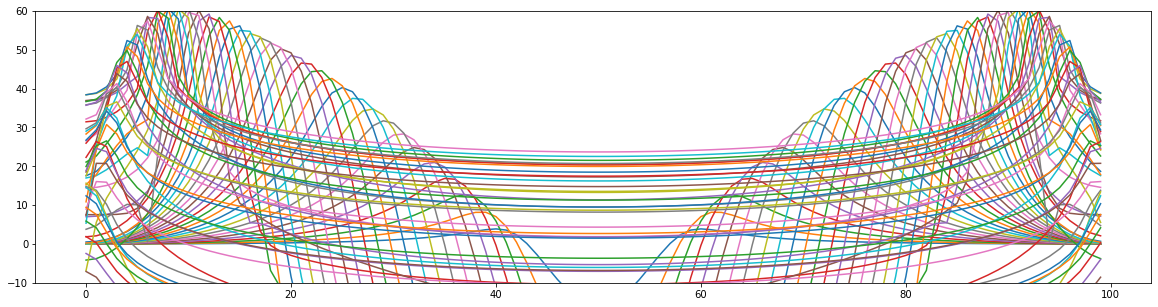

In [142]:
cc = CARCell()
car_layer = RNNWrapperLayer(cc)
impulse = np.zeros([3, 100], dtype=np.float64)
impulse[:,0] = 1
got = car_layer(tf.constant(impulse))
plt.figure(figsize=(20,5))
plt.ylim((-10,60))
for ch in range(got.shape[2]):
    spectrum = np.fft.fft(got[0, :, ch])
    plt.plot(np.arange(len(spectrum)), 20 * np.log10(np.abs(spectrum)))

(<tf.Tensor: shape=(1, 2048), dtype=complex128, numpy=
array([[-8.97887458e-05+0.j, -8.99203884e-05+0.j, -9.00897922e-05+0.j,
        ..., -8.96451839e-05+0.j, -8.96495392e-05+0.j,
        -8.96977788e-05+0.j]])>, <tf.Tensor: shape=(1, 1025), dtype=complex128, numpy=
array([[59.10062105+0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j]])>)


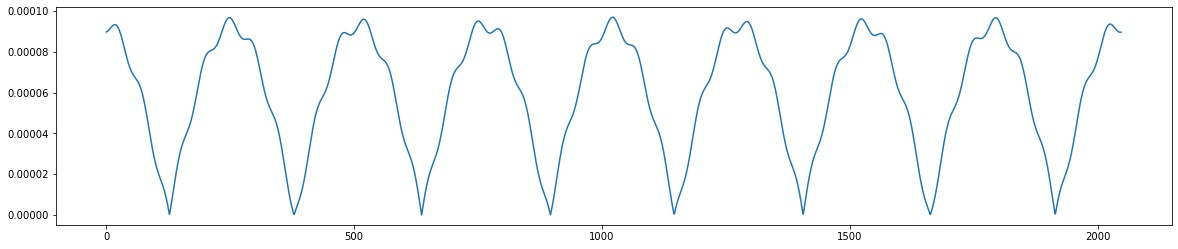

In [131]:
window_size = 2048
one_khz_examples = load_examples('/home/zond/DriveFileStream/My Drive/korvapuusti/listening_tests/modern_format/by_probe_center/1kHz/*/*.json').batch(1)
for ex in one_khz_examples.take(1):
    ex0 = ex
print(ex)
plt.figure(figsize=(20,4))
plt.plot(np.arange(window_size), np.abs(ex0[0][0,:window_size]))
plt.show()

In [132]:
assertequal(list(itertools.combinations(np.arange(5),4)), [[0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 3, 4], [0, 2, 3, 4], [1, 2, 3, 4]])

In [133]:
assertequal(coeffs(tf.constant([
    (-0.05429768147702485+1.4172655611120915e-05j),
    (0.2917622403739163+0.7731812636894612j),
    (0.8768382244780407-0.31120458350060115j),
    (0.6598943546882394-0.46728573398560225j),
    (-0.05429768147702485-1.4172655611120915e-05j),
    (0.2917622403739163-0.7731812636894612j),
    (0.8768382244780407+0.31120458350060115j),
    (0.6598943546882394+0.46728573398560225j)])), tf.constant([
    (1+0j), 
    (-3.548394276126343+5.551115123125783e-17j), 
    (5.916185211745642-3.885780586188048e-16j), 
    (-5.950823836910118-2.7755575615628914e-17j), 
    (3.819250686844303+3.3306690738754696e-16j),
    (-1.4222617112159746+8.326672684688674e-17j), 
    (0.1942351079538039-6.938893903907228e-18j), 
    (0.03639413827830768-2.8189256484623115e-18j), 
    (0.0011396243277688343+1.0842021724855044e-19j)]))

In [134]:
ear_cell = PZCell(tf.cast(1.34, dtype=tf.complex128),
                 tf.constant([
                     (-0.05429768147702485+1.4172655611120915e-05j),
                     (0.2917622403739163+0.7731812636894612j),
                     (0.8768382244780407-0.31120458350060115j),
                     (0.6598943546882394-0.46728573398560225j)
                 ], dtype=tf.complex128),
                 tf.constant([
                     (0.635496172349615+0.14499945287904842j),
                     (0.30987058966944614-0.8574194617385421j),
                     (0.5721096307971768-2.2915816453724273e-05j)
                 ], dtype=tf.complex128))
ear_layer = RNNWrapperLayer(ear_cell)
impulse = np.zeros([3, 10], dtype=np.float64)
impulse[:,0] = 1
got = ear_layer(impulse)
want_per_batch = [[ 0.                 ,  0.                 ,  1.340000033378601  ,
        0.6880116143997395 ,  0.5898482067084059 ,  0.26539000302780025,
       -0.17838450178081278, -0.535161973120797  , -0.6439493898291794 ,
       -0.5374803112705164 ]]
want = np.concatenate([want_per_batch, want_per_batch, want_per_batch], axis=0)
assertequal(got, want)

t1 0.7570202350616455
t2 0.022536754608154297


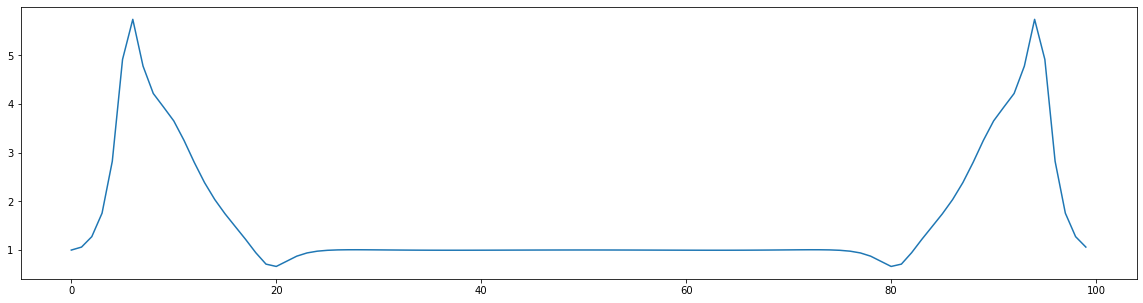

In [135]:
gain = tf.cast(1.34, dtype=tf.complex128)
poles = tf.constant([
                         (-0.05429768147702485+1.4172655611120915e-05j),
                         (0.2917622403739163+0.7731812636894612j),
                         (0.8768382244780407-0.31120458350060115j),
                         (0.6598943546882394-0.46728573398560225j)
                     ], dtype=tf.complex128)
zeros = tf.constant([
                         (0.635496172349615+0.14499945287904842j),
                         (0.30987058966944614-0.8574194617385421j),
                         (0.5721096307971768-2.2915816453724273e-05j)
                     ], dtype=tf.complex128)
ear_cell = PZCell(gain, poles, zeros)
ear_layer = RNNWrapperLayer(ear_cell)
impulse = np.zeros([1, 100], dtype=np.float64)
impulse[:,0] = 1
t = time.time()
got = ear_layer(impulse)
print('t1', time.time() - t)
t = time.time()
got = ear_layer(impulse)
print('t2', time.time() - t)

spectrum = np.fft.fft(got[0])
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(spectrum)), np.abs(spectrum))

In [9]:
poles = tf.Variable([0.25, 0.5, 0.75], dtype=tf.complex128)
tape = tf.GradientTape()
with tape:
    res = coeffs(poles)
tape.gradient(res, [poles])

[<tf.Tensor: shape=(3,), dtype=complex128, numpy=array([-0.125 +0.j, -0.1875+0.j, -0.375 +0.j])>]

In [10]:
poles = tf.Variable([0.25, 0.5, 0.75], dtype=tf.complex128)
zeros = tf.Variable([0.25j, 0.5j], dtype=tf.complex128)
gain = tf.Variable(1, dtype=tf.complex128)
ear_cell = PZCell(gain, poles, zeros)
state = ear_cell.get_initial_state(batch_size=1, dtype=tf.float64)
io = tf.ones([1], dtype=tf.float64)
with tape:
    for i in range(10):
        io, state = ear_cell.call(io, state)
tape.gradient(io, [gain, poles, zeros])

[<tf.Tensor: shape=(), dtype=complex128, numpy=(248.565185546875+0j)>,
 <tf.Tensor: shape=(3,), dtype=complex128, numpy=array([265.40820312+0.j, 303.56005859+0.j, 354.87304688+0.j])>,
 <tf.Tensor: shape=(2,), dtype=complex128, numpy=array([-232.92382812+26.15429688j, -225.04443359+50.52734375j])>]

In [11]:
poles = tf.Variable([0.25, 0.5, 0.75], dtype=tf.complex128)
zeros = tf.Variable([0.25j, 0.5j], dtype=tf.complex128)
gain = tf.Variable(1, dtype=tf.complex128)
ear_cell = PZCell(gain, poles, zeros)
ear_layer = RNNWrapperLayer(ear_cell)
step = np.zeros([1, 100], dtype=np.float64)
step[0] = 1
step = tf.constant(step)
tape = tf.GradientTape()
with tape:
    res = ear_layer(step)
tape.gradient(res, [gain, poles, zeros])

[<tf.Tensor: shape=(), dtype=complex128, numpy=(13421.037037059288+0j)>,
 <tf.Tensor: shape=(3,), dtype=complex128, numpy=array([ 35252.14814824+0.j,  52475.25925943+0.j, 102532.7407437 +0.j])>,
 <tf.Tensor: shape=(2,), dtype=complex128, numpy=array([-25012.1481482  +6181.92592594j, -21328.59259263+10543.40740743j])>]

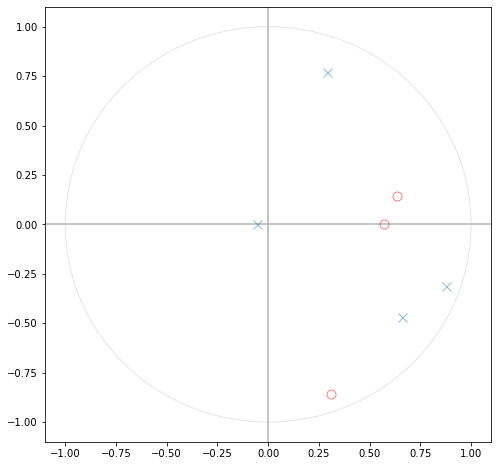

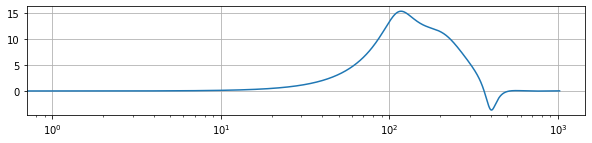

In [12]:
window_size = 2048
plot_pz(OuterEarLayer())
z = np.ones([1, 2048], dtype=np.complex128)
fy = tf.math.abs(OuterEarLayer()(z)[0])
y = 20 * np.log10(fy[:len(fy)//2])
plt.figure(figsize=(10,2))
plt.xscale('log')
plt.plot(np.arange(0, len(y)), y)
plt.grid(True)
plt.show()

In [ ]:
plot_many_z(CARLayer()(np.ones([1, 48000], dtype=np.complex128))[0])

In [ ]:
plot_snr(SNRLayer()(CARLayer()(OuterEarLayer()(ex0[0])))[0])

In [ ]:
print(LoudnessPredictorLayer()(SNRLayer()(CARLayer()(OuterEarLayer()(ex0[0])))))

In [ ]:
lpm = tf.keras.Sequential()
ear = OuterEarLayer(input_shape=[window_size])
lpm.add(ear)
car = CARLayer()
lpm.add(car)
snr = SNRLayer()
lpm.add(snr)
lpm.add(LoudnessPredictorLayer())
lpm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=LoudnessPredictorLoss())
(worst_index, worst_error, worst_example) = plot_pred(lpm, one_khz_examples)
print('worst error at', worst_index, worst_error)
plot_snr(snr(car(ear(worst_example[None,:])))[0])

In [ ]:
while True:
    lpm.fit(one_khz_examples, epochs=10, verbose=2)
    plot_pred(lpm, one_khz_examples)

In [ ]:
plot_pred(lpm, one_khz_examples)